In [3]:
import argparse
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.spatial.distance import cdist
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset

from src.propen import *
from src.utils import *


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataset
seed = 1
input_dim = 2
n_samples = 100
batch_size = 64
test_train_ratio = 0.2
num_workers = 5
n_hidden = 30
n_steps = 10
n_epochs = 300
propen_type = 'propen_mixup'

reset_seeds(seed)



### Generate toy dataset

Our toy data is 2d example whre the property of each point increases clock-wise.

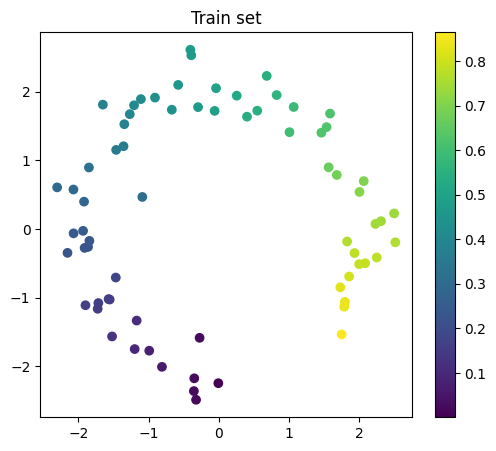

In [4]:
df_3d, compute_color_score, kde_3d = create_colored_dataset(n_size=n_samples, shape='8gaussians', seed=seed)
df_3d['z'] = compute_color(df_3d['y'], df_3d['x'])

df_3d_sorted = df_3d.sort_values('z', ascending=True)
df_3d_sorted_bottom = df_3d_sorted.head(70)

plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(df_3d_sorted_bottom['x'], df_3d_sorted_bottom['y'], c=df_3d_sorted_bottom['z'])
plt.title('Train set')
plt.colorbar()
plt.savefig('assets/train_data.png', dpi=180)
plt.show()

### Match dataset

Choose thresholds and do the matching. 

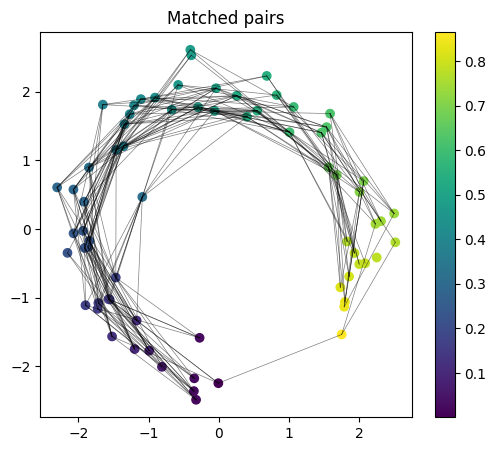

Train unique size: 59
Train pairs size: (223, 4)
Test pairs size: torch.Size([39, 2])


In [5]:
y_th = 0.1
x_th = 2

matched_pairs = match_dataset(np.asarray(df_3d_sorted_bottom[['x', 'y']]),
                              np.asarray(df_3d_sorted_bottom['z']),
                              y_th=y_th, x_th=x_th)

matched_train, matched_test = train_test_split(matched_pairs, test_size=test_train_ratio)
matched_test = matched_test[:, :input_dim]
matched_test = np.unique(matched_test, axis=0)
matched_test_tensor = torch.Tensor(matched_test[:, :input_dim])

matched_train_2d = matched_train[:, :input_dim]
matched_train_comp_2d = matched_train[:, input_dim:]

plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(df_3d_sorted_bottom['x'], df_3d_sorted_bottom['y'], c=df_3d_sorted_bottom['z'])

for i in range(matched_train_2d.shape[0]):
    plt.plot([matched_train_2d[i, 0], matched_train_comp_2d[i, 0]],
             [matched_train_2d[i, 1], matched_train_comp_2d[i, 1]],
             color='black', lw=0.5, alpha=0.5)

plt.colorbar()
plt.title('Matched pairs')
plt.savefig('assets/train_data_matched.png', dpi=180)
plt.show()

print('Train unique size:', np.unique(matched_train[:, :input_dim], axis=0).shape[0])
print('Train pairs size:', matched_train.shape)
print('Test pairs size:', matched_test_tensor.shape)


### Train a PropEn

In [8]:
pl.seed_everything(seed)
reset_seeds(seed)

# Data loaders
train_loader = DataLoader(
    MatchedDataset(matched_train),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

valid_loader = DataLoader(
    MatchedDataset(matched_test),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers,
)

model = MatchedAE(kde_3d, input_n=(input_dim),
                  n_hidden=n_hidden,
                  ae_type=propen_type)

model.to(device)
model.train()
print(model)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=n_epochs,
    logger=False,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    num_sanity_val_steps=1,
    val_check_interval=1,
    check_val_every_n_epoch=10,
    enable_progress_bar=True,
)

# Train the model
print("# Training commences ##########")
trainer.fit(model, train_loader, valid_loader)
print("# Training done ###############")

# Optimization steps
model.to(device)

Seed set to 1


MatchedAE(
  (criterion): MSELoss()
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=2, bias=True)
  )
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


# Training commences ##########


You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | encoder   | Sequential | 2.4 K 
2 | decoder   | Sequential | 2.4 K 
-----------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/tagasovn/.local/share/jupyter/3.4.2/lib/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


# Training done ###############


MatchedAE(
  (criterion): MSELoss()
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=2, bias=True)
  )
)

### Optimize designs

Initial designs average:
 AI=0.0015751069937 RI=100.0 NLL=-105.11771195850842 UQ=100.0 NOV=100.0 
 
Final designs average after 10 iterations:
 AI=0.017493622918283 RI=79.48717948717949 NLL=-194.2790758064834 UQ=100.0 NOV=100.0


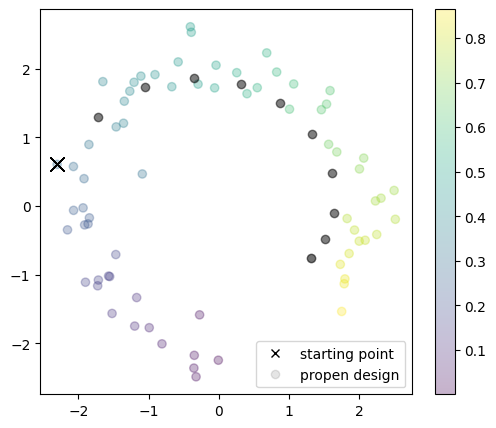

In [13]:
lst_n_propen_designs = n_steps_propen(matched_test_tensor, model, device, n_steps=n_steps)

ai, ri, ood, uq, nov = evaluate_designs(
    lst_n_propen_designs,
    matched_test_tensor[:, :2], 
    matched_train[:, :2], 
    kde_3d,
    compute_color_score
)

# Print initial and final metrics for all hold-out test examples

print(f"Initial designs average:\n AI={ai[0]} RI={ri[0]} NLL={ood[0]} UQ={uq[0]} NOV={nov[0]} \n ")
print(f"Final designs average after 10 iterations:\n AI={ai[-1]} RI={ri[-1]} NLL={ood[-1]} UQ={uq[-1]} NOV={nov[-1]}")

plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(df_3d_sorted_bottom['x'], df_3d_sorted_bottom['y'], c=df_3d_sorted_bottom['z'], alpha=0.3)
plt.colorbar()

# Visualize the optimization process for the first sample
new_pairs = []
for idx in range(matched_test_tensor.shape[0])[:1]:
    for op in range(n_steps):
        s1 = matched_test_tensor[idx, :]
        s2_idx = lst_n_propen_designs[op][idx].T
        new_pair = np.hstack([s1, s2_idx])
        new_pairs.append(new_pair)

        plt.plot(new_pair[2], new_pair[3], 'o', c='black', alpha=0.5)
        plt.plot(new_pair[0], new_pair[1], 'x', c='black', ms=10)

plt.plot(new_pair[0], new_pair[1], 'x', c='black', label='starting point')
plt.plot(new_pair[2], new_pair[3], 'o', c='black', alpha=0.1, label='propen design')
plt.legend()

new_pairs = np.asarray(new_pairs)
plt.show()